<a href="https://colab.research.google.com/github/lucasresck/deep-learning-and-applications/blob/main/cnn/cnn_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN architectures comparison

We will make various experiments with CNNs layers, activation functions and regularization techniques, and we will compare the results.

1. **Objective**: Use or create a deep CNN for COVID data set.
2. **Activities**: Create a deep model in PyTorch.
3. **Experiments**:
    - Increment number layer, from 1 to 5, and  analyze the results.
    - Experiment by changing the activation  functions (Tanh, ReLU) and analyze the results.
    - Experiment changing regularization strategies (1. without regularization; 2. with batch normalization; 3. with dropout).
    - With  a CNN with 3 layer, use kernel size:
        - (7x7,5x5,3x3)
        - (5x5,5x5,3x3)
        - (3x3,3x3,3x3)
4. Conclude from the results.


## Setup

In [ ]:
# Install libraries
!pip install -q kaggle  # For Kaggle dataset
!pip install -q split-folders  # Split the data

In [ ]:
# Import libraries
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import splitfolders
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms

sns.set()

In [ ]:
# GPU setup
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [ ]:
# Setup for downloading the Kaggle dataset
files.upload()  # Upload the Kaggle user API key
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


## Data

We download the COVID dataset from Kaggle. We split the data.

In [ ]:
# Download the files
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
# Unzip them
!unzip -q covid19-radiography-database.zip
# Remove files and folders
!rm 'covid19-radiography-database.zip'
!rm 'COVID-19 Radiography Database/COVID.metadata.xlsx'
!rm 'COVID-19 Radiography Database/NORMAL.metadata.xlsx'
!rm 'COVID-19 Radiography Database/README.md.txt'
!rm -rf 'COVID-19 Radiography Database/Viral Pneumonia'
!rm 'COVID-19 Radiography Database/Viral Pneumonia.metadata.xlsx'
# Split data
splitfolders.ratio('COVID-19 Radiography Database', output='data', seed=42, ratio=(0.8, 0.1, 0.1))
# Delete old files
!rm -rf 'COVID-19 Radiography Database'

 98% 1.12G/1.14G [00:05<00:00, 239MB/s]
100% 1.14G/1.14G [00:05<00:00, 236MB/s]


Copying files: 2541 files [00:12, 196.70 files/s]


We import the data sets and create the data loaders.

In [ ]:
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(256)
])
train_set = torchvision.datasets.ImageFolder(
    root='data/train',
    transform=transformation
)
val_set = torchvision.datasets.ImageFolder(
    root='data/val',
    transform=transformation
)
test_set = torchvision.datasets.ImageFolder(
    root='data/test',
    transform=transformation
)

In [ ]:
len(train_set)+len(val_set)+len(test_set)

2541

In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=64,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=64,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=64,
    shuffle=False
)

Here's an example of an image of the train dataset.

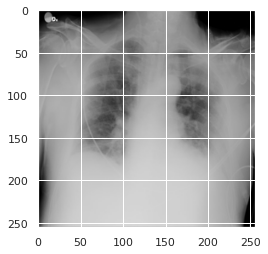

In [ ]:
plt.imshow(transforms.ToPILImage()(train_set[0][0]));

## Experiments

Here we perform the experiments proprosed in the beggining of our notebook.

In [ ]:
# Hyperparameters
lr = 0.001
n_epochs = 5

### Layers

We will vary the number of layers of the CNN and discuss the results.

#### 1 layer

In [ ]:
class CNN_1_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.linear1 = nn.Linear(
            in_features=16*128*128,
            out_features=64
        )
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.reshape(-1, 16*128*128)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_1_layer = CNN_1_layer().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_1_layer.parameters(), lr=lr)

In [ ]:
def train(model, optimizer, loss_function):
    losses = []
    val_losses = []
    val_accs = []
    for epoch in range(n_epochs):
        running_loss = 0
        model.train()
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()

            imgs, labels = data
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (i+1) % 10 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(
                    epoch+1,
                    n_epochs,
                    i+1,
                    len(train_loader),
                    loss.item()
                ))

        running_loss = running_loss/len(train_loader)
        print('Epoch [{}/{}], Mean loss: {:.4f}' .format(
            epoch+1,
            n_epochs,
            running_loss
        ), end='')
        losses.append(running_loss) 

        model.eval()
        val_loss = 0
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = loss_function(outputs, labels)
                val_loss += loss.item()
        val_acc = correct/total
        val_accs.append(val_acc)
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print(', Val loss: {:.4f}, Val acc: {:.3f}'.format(val_loss, val_acc))

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    sns.lineplot(x=list(range(1, 1+n_epochs)), y=losses, ax=axes[0], label='Train', marker='o')
    sns.lineplot(x=list(range(1, 1+n_epochs)), y=val_losses, ax=axes[0], label='Validation', marker='o')
    axes[0].set_title('Losses during training')
    axes[0].legend()
    axes[0].set_xlabel('Epoch')
    axes[0].set_xticks(list(range(1, 1+n_epochs)))
    axes[0].set_ylabel('Loss')

    sns.lineplot(x=list(range(1, 1+n_epochs)), y=val_accs, ax=axes[1], marker='o')
    axes[1].set_title('Validation accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_xticks(list(range(1, 1+n_epochs)))
    axes[1].set_ylabel('Accuracy')
    plt.show()

    return losses, val_losses, val_accs

Epoch [1/5], Step [10/32], Loss: 6.8481
Epoch [1/5], Step [20/32], Loss: 0.7684
Epoch [1/5], Step [30/32], Loss: 0.6002
Epoch [1/5], Mean loss: 3.9263, Val loss: 0.3165, Val acc: 0.965
Epoch [2/5], Step [10/32], Loss: 0.2080
Epoch [2/5], Step [20/32], Loss: 0.2699
Epoch [2/5], Step [30/32], Loss: 0.0376
Epoch [2/5], Mean loss: 0.2311, Val loss: 0.1309, Val acc: 0.969
Epoch [3/5], Step [10/32], Loss: 0.0421
Epoch [3/5], Step [20/32], Loss: 0.0024
Epoch [3/5], Step [30/32], Loss: 0.1792
Epoch [3/5], Mean loss: 0.1236, Val loss: 0.0874, Val acc: 0.972
Epoch [4/5], Step [10/32], Loss: 0.0026
Epoch [4/5], Step [20/32], Loss: 0.0515
Epoch [4/5], Step [30/32], Loss: 0.0344
Epoch [4/5], Mean loss: 0.0752, Val loss: 0.0708, Val acc: 0.976
Epoch [5/5], Step [10/32], Loss: 0.0271
Epoch [5/5], Step [20/32], Loss: 0.0185
Epoch [5/5], Step [30/32], Loss: 0.0272
Epoch [5/5], Mean loss: 0.0524, Val loss: 0.0460, Val acc: 0.984


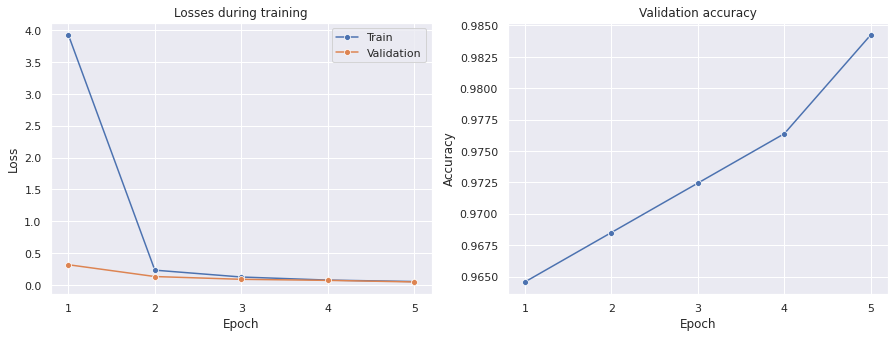

In [ ]:
losses, val_losses, val_accs = train(cnn_1_layer, optimizer, loss_function)

In [ ]:
def test(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct/total
    print('The accuracy of the model on test set is {:.4f}.'.format(acc))

In [ ]:
test(cnn_1_layer)

The accuracy of the model on test set is 0.9686.


#### 2 layers

In [ ]:
class CNN_2_layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.linear1 = nn.Linear(
            in_features=64*64*32,
            out_features=64
        )
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.reshape(-1, 64*64*32)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_2_layers = CNN_2_layers().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_2_layers.parameters(), lr=lr)

Epoch [1/5], Step [10/32], Loss: 0.1201
Epoch [1/5], Step [20/32], Loss: 0.0351
Epoch [1/5], Step [30/32], Loss: 0.0776
Epoch [1/5], Mean loss: 0.2923, Val loss: 0.1155, Val acc: 0.969
Epoch [2/5], Step [10/32], Loss: 0.1212
Epoch [2/5], Step [20/32], Loss: 0.2597
Epoch [2/5], Step [30/32], Loss: 0.0290
Epoch [2/5], Mean loss: 0.0468, Val loss: 0.0545, Val acc: 0.980
Epoch [3/5], Step [10/32], Loss: 0.0360
Epoch [3/5], Step [20/32], Loss: 0.0391
Epoch [3/5], Step [30/32], Loss: 0.0171
Epoch [3/5], Mean loss: 0.0284, Val loss: 0.0654, Val acc: 0.980
Epoch [4/5], Step [10/32], Loss: 0.0003
Epoch [4/5], Step [20/32], Loss: 0.0008
Epoch [4/5], Step [30/32], Loss: 0.0104
Epoch [4/5], Mean loss: 0.0133, Val loss: 0.0598, Val acc: 0.988
Epoch [5/5], Step [10/32], Loss: 0.0219
Epoch [5/5], Step [20/32], Loss: 0.0066
Epoch [5/5], Step [30/32], Loss: 0.0125
Epoch [5/5], Mean loss: 0.0090, Val loss: 0.0610, Val acc: 0.988


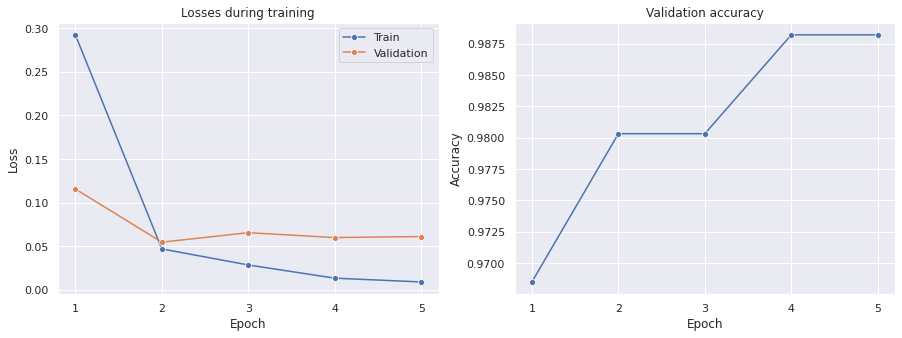

([0.29228405945468694,
  0.04682508057157975,
  0.028419711288734106,
  0.013278637413350225,
  0.008952289271292102],
 [0.11549765802919865,
  0.054544948681723326,
  0.06544425751781091,
  0.059825054835528135,
  0.061021830420941114],
 [0.968503937007874,
  0.9803149606299213,
  0.9803149606299213,
  0.9881889763779528,
  0.9881889763779528])

In [ ]:
train(cnn_2_layers, optimizer, loss_function);

In [ ]:
test(cnn_2_layers)

The accuracy of the model on test set is 0.9961.


#### 3 layers

In [ ]:
class CNN_3_layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 32, 3, 1, 1)
        self.linear1 = nn.Linear(
            in_features=32*32*32,
            out_features=64
        )
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.reshape(-1, 32*32*32)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_3_layers = CNN_3_layers().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_3_layers.parameters(), lr=lr)

Epoch [1/5], Step [10/32], Loss: 0.6613
Epoch [1/5], Step [20/32], Loss: 0.2691
Epoch [1/5], Step [30/32], Loss: 0.1355
Epoch [1/5], Mean loss: 0.4501, Val loss: 0.1123, Val acc: 0.972
Epoch [2/5], Step [10/32], Loss: 0.3609
Epoch [2/5], Step [20/32], Loss: 0.0659
Epoch [2/5], Step [30/32], Loss: 0.0715
Epoch [2/5], Mean loss: 0.1071, Val loss: 0.1045, Val acc: 0.972
Epoch [3/5], Step [10/32], Loss: 0.0556
Epoch [3/5], Step [20/32], Loss: 0.0893
Epoch [3/5], Step [30/32], Loss: 0.0382
Epoch [3/5], Mean loss: 0.0513, Val loss: 0.0708, Val acc: 0.969
Epoch [4/5], Step [10/32], Loss: 0.0120
Epoch [4/5], Step [20/32], Loss: 0.0059
Epoch [4/5], Step [30/32], Loss: 0.0318
Epoch [4/5], Mean loss: 0.0297, Val loss: 0.0617, Val acc: 0.980
Epoch [5/5], Step [10/32], Loss: 0.0170
Epoch [5/5], Step [20/32], Loss: 0.0177
Epoch [5/5], Step [30/32], Loss: 0.0006
Epoch [5/5], Mean loss: 0.0205, Val loss: 0.1128, Val acc: 0.980


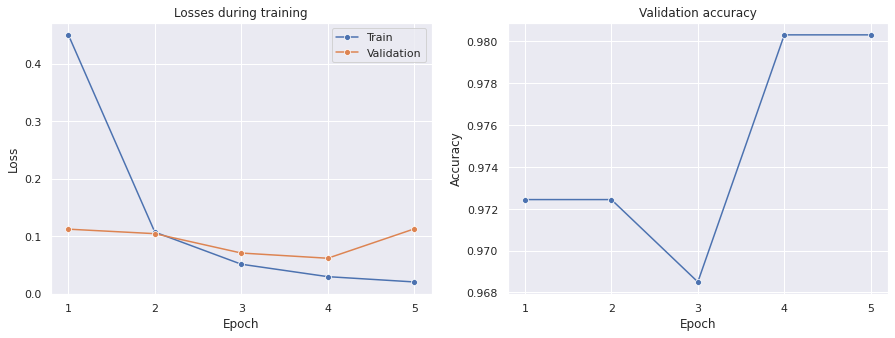

In [ ]:
train(cnn_3_layers, optimizer, loss_function);

In [ ]:
test(cnn_3_layers)

The accuracy of the model on test set is 0.9843.


#### 4 layers

In [ ]:
class CNN_4_layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 32, 3, 1, 1)
        self.conv4 = nn.Conv2d(32, 32, 3, 1, 1)
        self.linear1 = nn.Linear(
            in_features=16*16*32,
            out_features=64
        )
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = x.reshape(-1, 16*16*32)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_4_layers = CNN_4_layers().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_4_layers.parameters(), lr=lr)

Epoch [1/5], Step [10/32], Loss: 0.4894
Epoch [1/5], Step [20/32], Loss: 0.2032
Epoch [1/5], Step [30/32], Loss: 0.1294
Epoch [1/5], Mean loss: 0.3266, Val loss: 0.1066, Val acc: 0.969
Epoch [2/5], Step [10/32], Loss: 0.0267
Epoch [2/5], Step [20/32], Loss: 0.0986
Epoch [2/5], Step [30/32], Loss: 0.0474
Epoch [2/5], Mean loss: 0.0903, Val loss: 0.1299, Val acc: 0.957
Epoch [3/5], Step [10/32], Loss: 0.1709
Epoch [3/5], Step [20/32], Loss: 0.0604
Epoch [3/5], Step [30/32], Loss: 0.0755
Epoch [3/5], Mean loss: 0.0978, Val loss: 0.0739, Val acc: 0.976
Epoch [4/5], Step [10/32], Loss: 0.0365
Epoch [4/5], Step [20/32], Loss: 0.1259
Epoch [4/5], Step [30/32], Loss: 0.0506
Epoch [4/5], Mean loss: 0.0520, Val loss: 0.0555, Val acc: 0.976
Epoch [5/5], Step [10/32], Loss: 0.0370
Epoch [5/5], Step [20/32], Loss: 0.0383
Epoch [5/5], Step [30/32], Loss: 0.0094
Epoch [5/5], Mean loss: 0.0422, Val loss: 0.0592, Val acc: 0.972


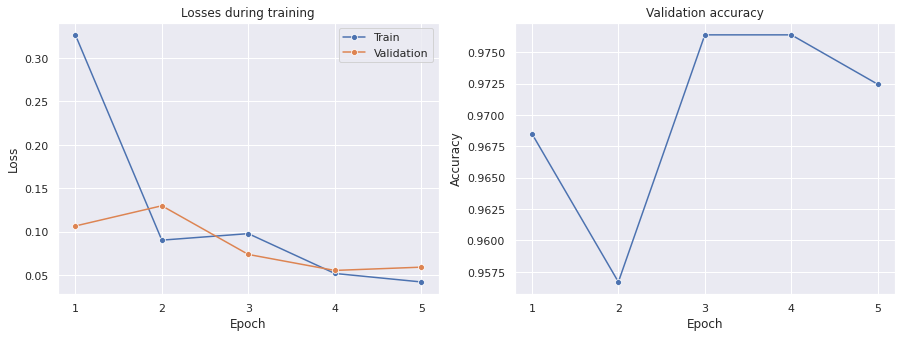

In [ ]:
train(cnn_4_layers, optimizer, loss_function);

In [ ]:
test(cnn_4_layers)

The accuracy of the model on test set is 0.9765.


#### 5 layers

In [ ]:
class CNN_5_layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 32, 3, 1, 1)
        self.conv4 = nn.Conv2d(32, 32, 3, 1, 1)
        self.conv5 = nn.Conv2d(32, 32, 3, 1, 1)
        self.linear1 = nn.Linear(
            in_features=8*8*32,
            out_features=64
        )
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.pool(self.relu(self.conv5(x)))
        x = x.reshape(-1, 8*8*32)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_5_layers = CNN_5_layers().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_5_layers.parameters(), lr=lr)

Epoch [1/5], Step [10/32], Loss: 0.6621
Epoch [1/5], Step [20/32], Loss: 0.2931
Epoch [1/5], Step [30/32], Loss: 0.2194
Epoch [1/5], Mean loss: 0.4375, Val loss: 0.1334, Val acc: 0.969
Epoch [2/5], Step [10/32], Loss: 0.0410
Epoch [2/5], Step [20/32], Loss: 0.1063
Epoch [2/5], Step [30/32], Loss: 0.0967
Epoch [2/5], Mean loss: 0.1048, Val loss: 0.0805, Val acc: 0.972
Epoch [3/5], Step [10/32], Loss: 0.1021
Epoch [3/5], Step [20/32], Loss: 0.1798
Epoch [3/5], Step [30/32], Loss: 0.2279
Epoch [3/5], Mean loss: 0.0900, Val loss: 0.1037, Val acc: 0.961
Epoch [4/5], Step [10/32], Loss: 0.0819
Epoch [4/5], Step [20/32], Loss: 0.1031
Epoch [4/5], Step [30/32], Loss: 0.0443
Epoch [4/5], Mean loss: 0.0715, Val loss: 0.0783, Val acc: 0.972
Epoch [5/5], Step [10/32], Loss: 0.0311
Epoch [5/5], Step [20/32], Loss: 0.0711
Epoch [5/5], Step [30/32], Loss: 0.0476
Epoch [5/5], Mean loss: 0.0515, Val loss: 0.0599, Val acc: 0.980


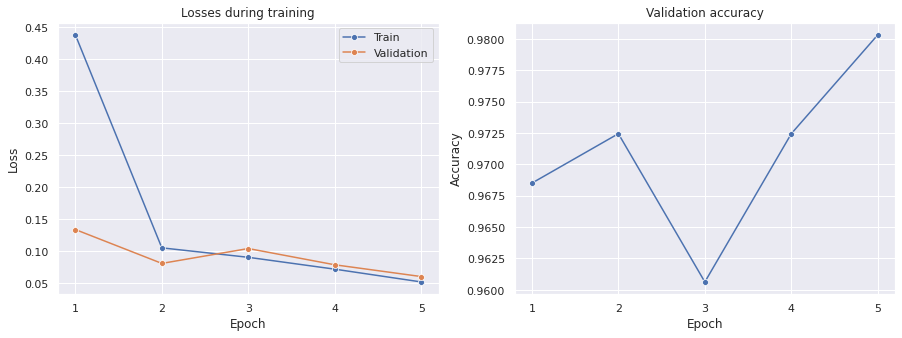

In [ ]:
train(cnn_5_layers, optimizer, loss_function);

In [ ]:
test(cnn_5_layers)

The accuracy of the model on test set is 0.9765.


#### Comparison

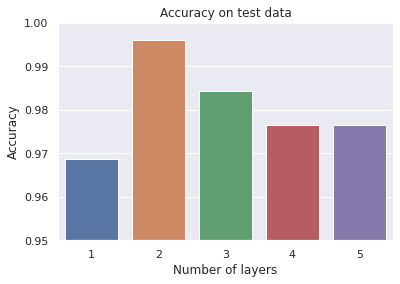

In [ ]:
fig, ax = plt.subplots(1, 1)
sns.barplot(x=list(range(1, 6)), y=[0.9686, 0.9961, 0.9843, 0.9765, 0.9765], ax=ax)
ax.set_ylim([0.95, 1])
plt.title('Accuracy on test data')
plt.xlabel('Number of layers')
plt.ylabel('Accuracy')
plt.show()

With our results, we conclude that the best model was the one with **2 layers**. Maybe 1 layer is not enough to generalize, and maybe more than 2 layers needs more data to generalize well.

### Activation functions

We will experiment with some activate functions and discuss the results. Because of the experiments with various number of layers, we will choose to work with 2 layers.

#### ReLU

It was already fitted in the previous section (2 layers CNN).

#### Tanh

In [ ]:
class CNN_tanh(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.tanh = nn.Tanh()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.linear1 = nn.Linear(
            in_features=64*64*32,
            out_features=64
        )
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.tanh(self.pool(self.conv1(x)))
        x = self.tanh(self.pool(self.conv2(x)))
        x = x.reshape(-1, 64*64*32)
        x = self.tanh(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_tanh = CNN_tanh().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_tanh.parameters(), lr=lr)

Epoch [1/5], Step [10/32], Loss: 2.5092
Epoch [1/5], Step [20/32], Loss: 1.7699
Epoch [1/5], Step [30/32], Loss: 0.9688
Epoch [1/5], Mean loss: 1.8779, Val loss: 1.0071, Val acc: 0.472
Epoch [2/5], Step [10/32], Loss: 0.7537
Epoch [2/5], Step [20/32], Loss: 0.7010
Epoch [2/5], Step [30/32], Loss: 0.7062
Epoch [2/5], Mean loss: 0.7540, Val loss: 0.6995, Val acc: 0.528
Epoch [3/5], Step [10/32], Loss: 0.7137
Epoch [3/5], Step [20/32], Loss: 0.6931
Epoch [3/5], Step [30/32], Loss: 0.6990
Epoch [3/5], Mean loss: 0.6947, Val loss: 0.6915, Val acc: 0.528
Epoch [4/5], Step [10/32], Loss: 0.6748
Epoch [4/5], Step [20/32], Loss: 0.7056
Epoch [4/5], Step [30/32], Loss: 0.6905
Epoch [4/5], Mean loss: 0.6925, Val loss: 0.6916, Val acc: 0.528
Epoch [5/5], Step [10/32], Loss: 0.6884
Epoch [5/5], Step [20/32], Loss: 0.6851
Epoch [5/5], Step [30/32], Loss: 0.7020
Epoch [5/5], Mean loss: 0.6924, Val loss: 0.6914, Val acc: 0.528


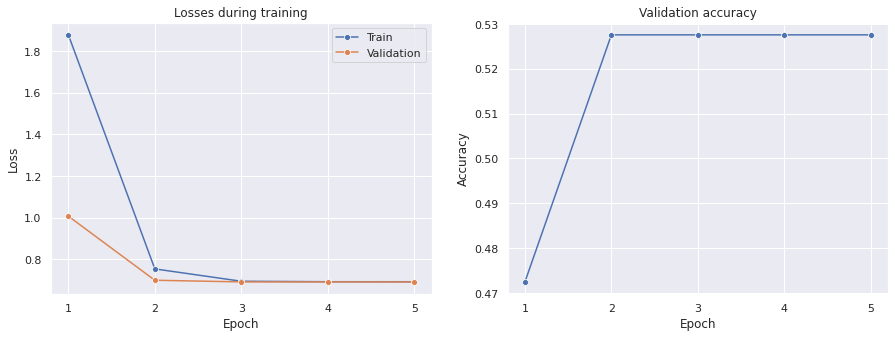

In [ ]:
train(cnn_tanh, optimizer, loss_function);

In [ ]:
test(cnn_tanh)

The accuracy of the model on test set is 0.5294.


#### Comparison

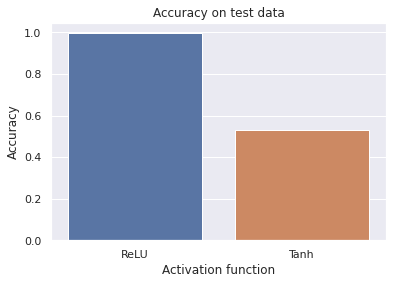

In [ ]:
fig, ax = plt.subplots(1, 1)
sns.barplot(x=['ReLU', 'Tanh'], y=[0.9961, 0.5294], ax=ax)
plt.title('Accuracy on test data')
plt.xlabel('Activation function')
plt.ylabel('Accuracy')
plt.show()

With our results, we conclude that the best model was by far the one with **ReLU**.

### Regularization strategies

We will experiment various regularization strategies.

#### Without regularization

Consider the 2 layers CNN with ReLU.

#### Batch normalization

In [ ]:
class CNN_batch_normalization(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn_1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.bn_2 = nn.BatchNorm2d(32)
        self.linear1 = nn.Linear(
            in_features=64*64*32,
            out_features=64
        )
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.bn_1(self.conv1(x))))
        x = self.pool(self.relu(self.bn_2(self.conv2(x))))
        x = x.reshape(-1, 64*64*32)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_batch_normalization = CNN_batch_normalization().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_batch_normalization.parameters(), lr=lr)

Epoch [1/5], Step [10/32], Loss: 1.9413
Epoch [1/5], Step [20/32], Loss: 0.2043
Epoch [1/5], Step [30/32], Loss: 0.0000
Epoch [1/5], Mean loss: 0.8001, Val loss: 19.1800, Val acc: 0.476
Epoch [2/5], Step [10/32], Loss: 0.3268
Epoch [2/5], Step [20/32], Loss: 0.0000
Epoch [2/5], Step [30/32], Loss: 0.0000
Epoch [2/5], Mean loss: 0.1124, Val loss: 0.6481, Val acc: 0.969
Epoch [3/5], Step [10/32], Loss: 0.0153
Epoch [3/5], Step [20/32], Loss: 0.0000
Epoch [3/5], Step [30/32], Loss: 0.0000
Epoch [3/5], Mean loss: 0.0797, Val loss: 0.2705, Val acc: 0.988
Epoch [4/5], Step [10/32], Loss: 0.0000
Epoch [4/5], Step [20/32], Loss: 0.0002
Epoch [4/5], Step [30/32], Loss: 0.0000
Epoch [4/5], Mean loss: 0.0611, Val loss: 0.7212, Val acc: 0.976
Epoch [5/5], Step [10/32], Loss: 0.0000
Epoch [5/5], Step [20/32], Loss: 0.5738
Epoch [5/5], Step [30/32], Loss: 0.0000
Epoch [5/5], Mean loss: 0.2506, Val loss: 0.4011, Val acc: 0.980


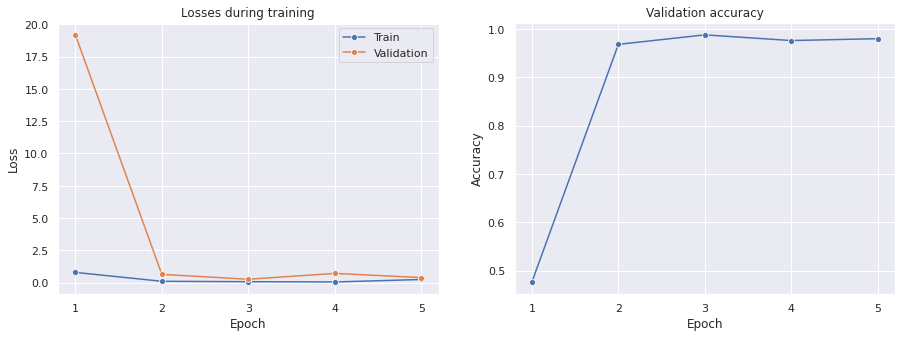

In [ ]:
train(cnn_batch_normalization, optimizer, loss_function);

In [ ]:
test(cnn_batch_normalization)

The accuracy of the model on test set is 0.9882.


#### Dropout

In [ ]:
class CNN_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.linear1 = nn.Linear(
            in_features=64*64*32,
            out_features=64
        )
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.dropout(self.relu(self.conv1(x))))
        x = self.pool(self.dropout(self.relu(self.conv2(x))))
        x = x.reshape(-1, 64*64*32)
        x = self.dropout(self.relu(self.linear1(x)))
        x = self.linear2(x)
        return x

cnn_dropout = CNN_dropout().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_dropout.parameters(), lr=lr)

Epoch [1/5], Step [10/32], Loss: 1.2205
Epoch [1/5], Step [20/32], Loss: 0.2150
Epoch [1/5], Step [30/32], Loss: 0.2117
Epoch [1/5], Mean loss: 1.4236, Val loss: 0.3121, Val acc: 0.957
Epoch [2/5], Step [10/32], Loss: 0.1994
Epoch [2/5], Step [20/32], Loss: 0.0761
Epoch [2/5], Step [30/32], Loss: 0.0492
Epoch [2/5], Mean loss: 0.1085, Val loss: 0.1721, Val acc: 0.980
Epoch [3/5], Step [10/32], Loss: 0.0182
Epoch [3/5], Step [20/32], Loss: 0.0584
Epoch [3/5], Step [30/32], Loss: 0.0339
Epoch [3/5], Mean loss: 0.0685, Val loss: 0.2146, Val acc: 0.976
Epoch [4/5], Step [10/32], Loss: 0.0558
Epoch [4/5], Step [20/32], Loss: 0.1760
Epoch [4/5], Step [30/32], Loss: 0.0229
Epoch [4/5], Mean loss: 0.0743, Val loss: 0.1580, Val acc: 0.980
Epoch [5/5], Step [10/32], Loss: 0.0144
Epoch [5/5], Step [20/32], Loss: 0.1361
Epoch [5/5], Step [30/32], Loss: 0.0292
Epoch [5/5], Mean loss: 0.0505, Val loss: 0.2268, Val acc: 0.969


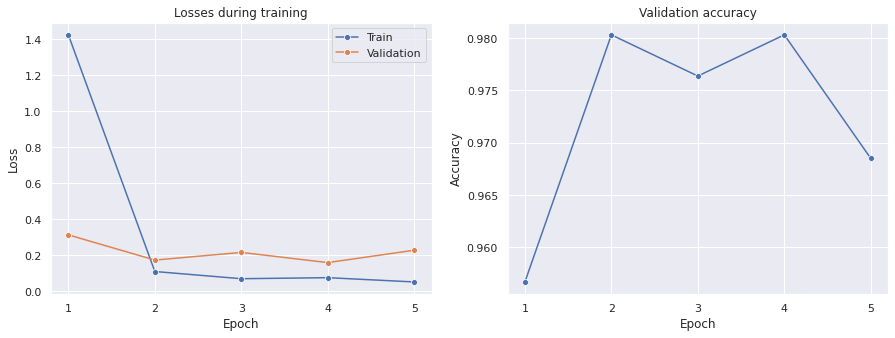

In [ ]:
train(cnn_dropout, optimizer, loss_function);

In [ ]:
test(cnn_dropout)

The accuracy of the model on test set is 0.9451.


#### Comparison

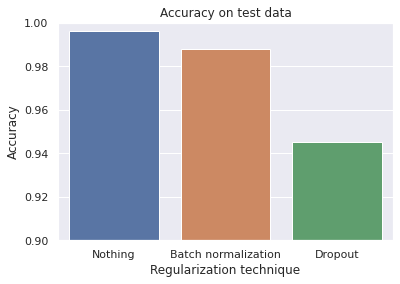

In [ ]:
fig, ax = plt.subplots(1, 1)
sns.barplot(x=['Nothing', 'Batch normalization', 'Dropout'], y=[0.9961, 0.9882, 0.9451], ax=ax)
plt.title('Accuracy on test data')
plt.xlabel('Regularization technique')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.show()

With our results, we conclude that the best model was the one without any regularization technique. Maybe it happened because we didn't choose the best regularization parameters we could, or the model without regularization is already good enough. We note that the model with batch normalization could be fitted with only one epoch.

### Kernel size

We will experiment various kernel sizes.

#### (7x7, 5x5, 3x3)



In [ ]:
class CNN_753(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=7,
            stride=1,
            padding=3
        )
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.conv3 = nn.Conv2d(32, 32, 3, 1, 1)
        self.linear1 = nn.Linear(
            in_features=32*32*32,
            out_features=64
        )
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.reshape(-1, 32*32*32)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_753 = CNN_753().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_753.parameters(), lr=lr)

Epoch [1/5], Step [10/32], Loss: 0.1544
Epoch [1/5], Step [20/32], Loss: 0.1424
Epoch [1/5], Step [30/32], Loss: 0.1446
Epoch [1/5], Mean loss: 0.2293, Val loss: 0.0830, Val acc: 0.980
Epoch [2/5], Step [10/32], Loss: 0.1129
Epoch [2/5], Step [20/32], Loss: 0.0070
Epoch [2/5], Step [30/32], Loss: 0.0630
Epoch [2/5], Mean loss: 0.0696, Val loss: 0.0541, Val acc: 0.980
Epoch [3/5], Step [10/32], Loss: 0.0367
Epoch [3/5], Step [20/32], Loss: 0.1935
Epoch [3/5], Step [30/32], Loss: 0.0525
Epoch [3/5], Mean loss: 0.0595, Val loss: 0.0727, Val acc: 0.972
Epoch [4/5], Step [10/32], Loss: 0.0226
Epoch [4/5], Step [20/32], Loss: 0.0276
Epoch [4/5], Step [30/32], Loss: 0.0523
Epoch [4/5], Mean loss: 0.0551, Val loss: 0.0575, Val acc: 0.984
Epoch [5/5], Step [10/32], Loss: 0.0190
Epoch [5/5], Step [20/32], Loss: 0.0092
Epoch [5/5], Step [30/32], Loss: 0.0105
Epoch [5/5], Mean loss: 0.0315, Val loss: 0.0962, Val acc: 0.972


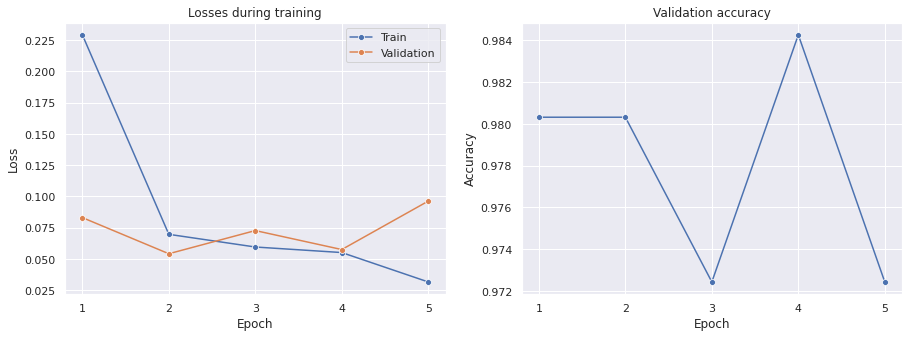

([0.2293335209833458,
  0.06963836986687966,
  0.05949479412083747,
  0.05505989273660816,
  0.03152696475444827],
 [0.083037537522614,
  0.05411125405225903,
  0.0726574151776731,
  0.05746414512395859,
  0.09623379562981427],
 [0.9803149606299213,
  0.9803149606299213,
  0.9724409448818898,
  0.984251968503937,
  0.9724409448818898])

In [ ]:
train(cnn_753, optimizer, loss_function)

In [ ]:
test(cnn_753)

The accuracy of the model on test set is 0.9490.


#### (5x5, 5x5, 3x3)



In [ ]:
class CNN_553(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=5,
            stride=1,
            padding=2
        )
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.conv3 = nn.Conv2d(32, 32, 3, 1, 1)
        self.linear1 = nn.Linear(
            in_features=32*32*32,
            out_features=64
        )
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.reshape(-1, 32*32*32)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_553 = CNN_553().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_553.parameters(), lr=lr)

Epoch [1/5], Step [10/32], Loss: 0.2710
Epoch [1/5], Step [20/32], Loss: 0.1258
Epoch [1/5], Step [30/32], Loss: 0.1259
Epoch [1/5], Mean loss: 0.2744, Val loss: 0.0823, Val acc: 0.972
Epoch [2/5], Step [10/32], Loss: 0.2178
Epoch [2/5], Step [20/32], Loss: 0.0194
Epoch [2/5], Step [30/32], Loss: 0.0879
Epoch [2/5], Mean loss: 0.0737, Val loss: 0.0720, Val acc: 0.980
Epoch [3/5], Step [10/32], Loss: 0.0167
Epoch [3/5], Step [20/32], Loss: 0.1513
Epoch [3/5], Step [30/32], Loss: 0.0263
Epoch [3/5], Mean loss: 0.0503, Val loss: 0.0433, Val acc: 0.972
Epoch [4/5], Step [10/32], Loss: 0.0090
Epoch [4/5], Step [20/32], Loss: 0.1254
Epoch [4/5], Step [30/32], Loss: 0.0284
Epoch [4/5], Mean loss: 0.0499, Val loss: 0.0445, Val acc: 0.992
Epoch [5/5], Step [10/32], Loss: 0.0129
Epoch [5/5], Step [20/32], Loss: 0.0654
Epoch [5/5], Step [30/32], Loss: 0.0844
Epoch [5/5], Mean loss: 0.0406, Val loss: 0.0615, Val acc: 0.976


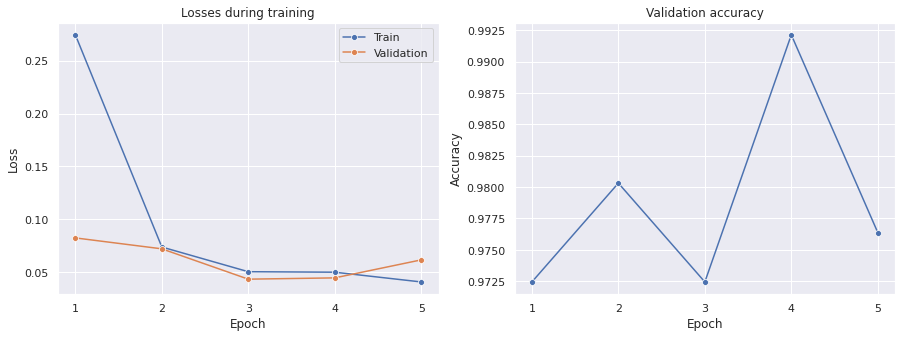

In [ ]:
train(cnn_553, optimizer, loss_function);

In [ ]:
test(cnn_553)

The accuracy of the model on test set is 0.9804.


#### (3x3, 3x3, 3x3)



In [ ]:
class CNN_333(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=1,
            stride=1,
            padding=1
        )
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 32, 3, 1, 1)
        self.linear1 = nn.Linear(
            in_features=32*32*32,
            out_features=64
        )
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.reshape(-1, 32*32*32)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_333 = CNN_333().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_333.parameters(), lr=lr)

Epoch [1/5], Step [10/32], Loss: 0.6406
Epoch [1/5], Step [20/32], Loss: 0.2521
Epoch [1/5], Step [30/32], Loss: 0.1278
Epoch [1/5], Mean loss: 0.4132, Val loss: 0.0834, Val acc: 0.969
Epoch [2/5], Step [10/32], Loss: 0.0530
Epoch [2/5], Step [20/32], Loss: 0.0083
Epoch [2/5], Step [30/32], Loss: 0.1920
Epoch [2/5], Mean loss: 0.0826, Val loss: 0.0520, Val acc: 0.969
Epoch [3/5], Step [10/32], Loss: 0.0060
Epoch [3/5], Step [20/32], Loss: 0.0176
Epoch [3/5], Step [30/32], Loss: 0.0793
Epoch [3/5], Mean loss: 0.0565, Val loss: 0.0569, Val acc: 0.976
Epoch [4/5], Step [10/32], Loss: 0.0665
Epoch [4/5], Step [20/32], Loss: 0.1016
Epoch [4/5], Step [30/32], Loss: 0.0909
Epoch [4/5], Mean loss: 0.0570, Val loss: 0.0492, Val acc: 0.980
Epoch [5/5], Step [10/32], Loss: 0.0692
Epoch [5/5], Step [20/32], Loss: 0.0339
Epoch [5/5], Step [30/32], Loss: 0.0288
Epoch [5/5], Mean loss: 0.0465, Val loss: 0.0441, Val acc: 0.976


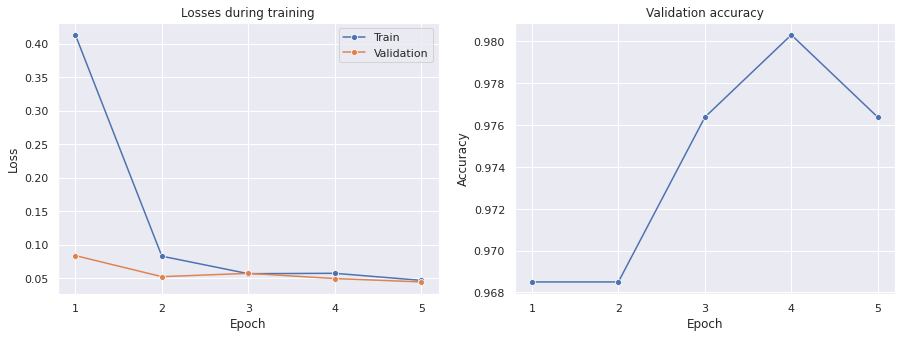

([0.413159454241395,
  0.08259613648988307,
  0.056456945050740615,
  0.05701447557657957,
  0.04646692841197364],
 [0.08344956499058753,
  0.05200998287182301,
  0.056941766291856766,
  0.049189397890586406,
  0.04410898982314393],
 [0.968503937007874,
  0.968503937007874,
  0.9763779527559056,
  0.9803149606299213,
  0.9763779527559056])

In [ ]:
train(cnn_333, optimizer, loss_function)

In [ ]:
test(cnn_333)

The accuracy of the model on test set is 0.9765.


#### Comparison

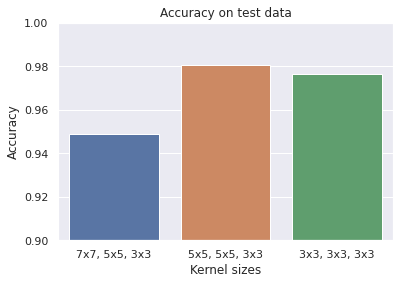

In [ ]:
fig, ax = plt.subplots(1, 1)
sns.barplot(x=['7x7, 5x5, 3x3', '5x5, 5x5, 3x3', '3x3, 3x3, 3x3'], y=[0.9490, 0.9804, 0.9765], ax=ax)
plt.title('Accuracy on test data')
plt.xlabel('Kernel sizes')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.show()

The best model was the one with kernel sizes 5, 5, 3.

## Conclusions

In general, we could conjecture the best model for this task has some of these characteristics:
- 2 layers
- ReLU
- No regularization
- 3 layers and kernel sizes 5, 5, 3.

In fact, CNN with ReLU, 2 layers and no regularization performed the best.

It seems the most important comparison was the activation function: ReLU was much better than Tanh.

## References

M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam, “Can AI help in screening Viral and COVID-19 pneumonia?” IEEE Access, Vol. 8, 2020, pp. 132665 - 132676.